# Exercise : Convolution Neural Network

In [41]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import os
import random

In [42]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [43]:
# Download data and define the transformer (data normalization)
# Do not change this function
def load_data(seed_value=42):
  MNIST_normalize = transforms.Normalize((0.1307,), (0.3081,))
  MNIST_transform = transforms.Compose([
      transforms.ToTensor(),
      MNIST_normalize
  ])

  # MNIST Dataset
  train = datasets.MNIST(root='./data/',
                                train=True,
                                transform=MNIST_transform,
                                download=True)

  test = datasets.MNIST(root='./data/',
                                train=False,
                                transform=MNIST_transform)

  #print(valid.dataset.data.shape)
  train_subset_size = 5000
  train.data = train.data[0:train_subset_size]
  train.targets = train.targets[0:train_subset_size]

  train_size = int(0.9 * train_subset_size)
  val_size =  int(0.1 * train_subset_size)
  print("train_set_size:", train_size)
  print("val_set_size:", val_size)

  train, valid = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(seed_value))

  return train, valid, test

In [44]:
# function to show data
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [45]:
# Data Loader 
def get_data_loaders(dataset, batch_size, shuffle=True):
  loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=shuffle)
  return loader

In [46]:
# Model
class Conv_Net(nn.Module):
    def __init__(self, dropout_value=0.5):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3)   # 1 * 128 * 3
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3) # 128 * 256 * 3
        self.mp = nn.MaxPool2d(2)                       # maxpooling
        self.drop = nn.Dropout(dropout_value)           # decrease overfitting
        self.fc = nn.Linear(6400, 10)                   # full connection layer, input dimension: 6400, output dimension: 10

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))  # activations, kernel layer 1
        x = F.relu(self.mp(self.conv2(x)))  # activations, kernel layer 2
        x = x.view(in_size, -1)             # flatten the tensor
        x = self.drop(x)
        x = self.fc(x)
        return F.log_softmax(x)

In [47]:
def train(epoch, train_loader, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


In [48]:
def test(test_loader, device, is_train_set=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
          data, target = Variable(data).to(device), Variable(target).to(device)
          output = model(data)
          # sum up batch loss
          test_loss += F.nll_loss(output, target, size_average=False).data
          # get the index of the max log-probability
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\n{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        'Train evaluation' if is_train_set else 'Val/Test evaluation', test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [49]:
# seed_everything(seed=42)
# # Training settings
# batch_size = 128
# lr = 0.1
# momentum = 0.9 
# l2 = 0.0
# l2 = 0.05
# dropout_value = 0.0
# # dropout_value = 0.5
# num_epochs = 15
# # device = 'cuda'
# device = ('cuda' if torch.cuda.is_available() else 'cpu')

# # define the network
# model = Conv_Net(dropout_value).to(device)

# # define the optimizer 
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay= l2)

# train_dataset, val_dataset, test_dataset = load_data()

# #divide data to train and val
# train_loader = get_data_loaders(train_dataset, batch_size, shuffle=True)
# val_loader = get_data_loaders(val_dataset, batch_size, shuffle=False)
# test_loader = get_data_loaders(test_dataset, batch_size, shuffle=False)


# for epoch in range(1, num_epochs):
#     train(epoch, train_loader, device)
#     test(train_loader, device, is_train_set=True)
#     test(val_loader, device, is_train_set=False)


# test(test_loader, device, is_train_set=False)

<font size="5">**Options:**</font>

A: False. Using the default hyper-parameters, the accuracy on test set is not always higher than the accuracy on validation set. Sometimes, its value is 95% while the value on validation set is 96%.

B: False. Although the accuracies on validaition set and on test set are both lower than that on training set, the three accuracies are overall sufficiently high, i.e. at least 95%. Therefore, the model does not suffer from uderfitting.

C: True. The difference between the accuracy on training set and test set after setting 'dropout' 0.5 is lower than that of default hyper-parameters.

D: False. After setting l2 = 0.05, the accuracies on the three sets decrease to about 93%. That means, the predictions of the new models are worse than the default one. Thus, the underfitting increases.

<u>default</u>

**local output**

*Train evaluation: Average loss: 0.0234, Accuracy: 4463/4500 (99%)*


*Val/Test evaluation: Average loss: 0.2973, Accuracy: 478/500 (96%)*


*Val/Test evaluation: Average loss: 0.2744, Accuracy: 9523/10000 (95%)*

**Colab output**

*Train evaluation: Average loss: 0.0141, Accuracy: 4477/4500 (99%)*


*Val/Test evaluation: Average loss: 0.1646, Accuracy: 477/500 (95%)*


*Val/Test evaluation: Average loss: 0.2057, Accuracy: 9613/10000 (96%)*

</br>
<u>dropout = 0.5</u>

**local output**:

*Train evaluation: Average loss: 0.0241, Accuracy: 4465/4500 (99%)*

*Val/Test evaluation: Average loss: 0.0732, Accuracy: 485/500 (97%)*

*Val/Test evaluation: Average loss: 0.0776, Accuracy: 9766/10000 (98%)*

**Colab output**:

*Train evaluation: Average loss: 0.0243, Accuracy: 4467/4500 (99%)*


*Val/Test evaluation: Average loss: 0.0661, Accuracy: 486/500 (97%)*


*Val/Test evaluation: Average loss: 0.0896, Accuracy: 9704/10000 (97%)*


</br>
<u>l2 = 0.05</u>

**local output**:

*Train evaluation: Average loss: 0.2857, Accuracy: 4132/4500 (92%)*


*Val/Test evaluation: Average loss: 0.2913, Accuracy: 458/500 (92%)*


*Val/Test evaluation: Average loss: 0.3017, Accuracy: 9147/10000 (91%)*

**Colab output**:

*Train evaluation: Average loss: 0.2841, Accuracy: 4205/4500 (93%)*


*Val/Test evaluation: Average loss: 0.3038, Accuracy: 463/500 (93%)*


*Val/Test evaluation: Average loss: 0.2935, Accuracy: 9362/10000 (94%)*



--------------------------------

In [50]:
!pip3 install JSAnimation

In [51]:
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import matplotlib.pyplot as plt # data visualization library
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA   
from JSAnimation import IPython_display
from matplotlib import animation
from IPython.display import HTML

# Exercise : MF Faces(Matrix Factorization)

In [52]:
faces = fetch_olivetti_faces()
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

Definition of the data matrix:

In [53]:
D = faces.data

The observations/rows of the data matrix can be visualized as pictures. 10 consecutive pictures are taken from one person. This are the first 30 pictutres.

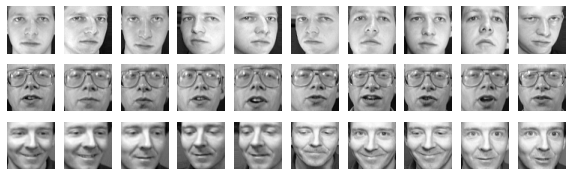

In [54]:
# Here are the first ten guys of the dataset
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
    ax.imshow(D[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

<font size=6>PCA Faces</font>

In [55]:
from sklearn.decomposition import TruncatedSVD

# implementation of PCA algorithm
print(D.shape)      # 400 * 4096 = 400 * 64 * 64: 400行，每10行属于一个人脸，每一行代表一张64*64像素的照片

# vector: means of all features
μF = np.mean(D, axis=0)


(400, 4096)


The picture represented by µF looks like this:


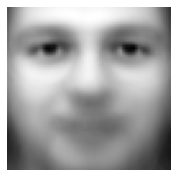

In [56]:
print("The picture represented by µF looks like this:")
fig = plt.figure(figsize=(9, 3))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.imshow(μF.reshape(64, 64), cmap=plt.cm.gray)
ax.set_axis_off()

In [57]:
# centered data matrix
C = D - μF

print(C.shape)

U, Σ, Vᵀ = np.linalg.svd(C,full_matrices=True)
# print(U.shape)
# print(Σ.shape)
# print(Vᵀ.shape)

(400, 4096)


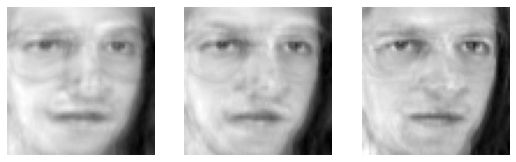

In [58]:
r = np.array([25, 50, 100])

fig = plt.figure(figsize=(9, 3))
for i in range(0, 3):
    V = Vᵀ.T[:, 0:r[i]]
    pca = C@V
    # reconstruction
    D_pca = pca@V.T + μF
    # plot
    ax = plt.subplot2grid((1, 3), (0, i))
    ax.imshow(D_pca[1, :].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

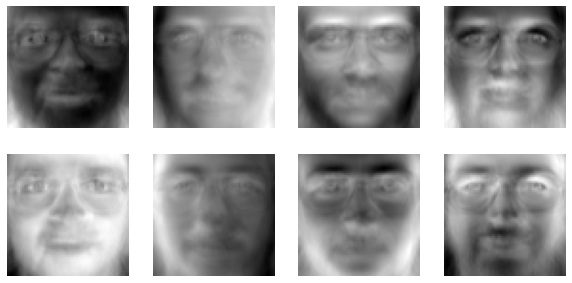

In [59]:
r = 4
V = Vᵀ.T[:, 0:r]
V_minus = -V
# pca = C@V
# D_pca = pca@V.T

# fig = plt.figure()
# for i in range(0, 4):
#     ax = plt.subplot2grid((2, 4), (int(i/4), i-int(i/4)*4))
#     ax.imshow(D_pca[i, :].reshape(64, 64), cmap=plt.cm.gray)
#     ax.axis('off')

fig = plt.figure(figsize=(10, 5))
for i in range(0, 8):
    ax = plt.subplot2grid((2, 4), (int(i/4), i-int(i/4)*4))
    if i < 4:
        ax.imshow(V[:, i].reshape(64, 64), cmap=plt.cm.gray)
    else:
        i -= 4
        ax.imshow(V_minus[:, i].reshape(64, 64), cmap=plt.cm.gray)
        i += 4
    ax.axis('off')

**疑问**

关于Question 2的原理
- reconstruction是针对图像处理的时候使用吗？
- reconstruction会导致维度与初始维度相同，而PCA是降维？不过使用PCA后reconstruction的图像明显是压缩过的
- 选项C选几张图是自己定义的吗

<font size=6>k-means and SVD Faces</font>


In [60]:
# k-means clustering and truncated SVD
D = faces.data
# C = D - np.mean(D, axis=0)
# U, Σ, Vᵀ = np.linalg.svd(C,full_matrices=True)
U, Σ, Vᵀ = np.linalg.svd(D,full_matrices=True)


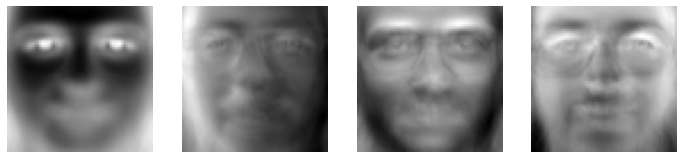

In [61]:
# feature spaces by truncated SVD: The right singular vectors of C.
r = 4
V = Vᵀ.T[:, 0:r]
fig = plt.figure(figsize=(12, 4))
for i in range(0, r):
    ax = plt.subplot2grid((1, r), (int(i/r), i-int(i/r)*r))
    ax.imshow(V.T[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

In [62]:
X = V
Y = U[:, 0:r] * Σ[0:r]
# print(X.shape)
# print(Y.shape)
# print((Y@X.T).shape)
recon = Y@X.T

In [63]:
from sklearn.cluster import KMeans

In [64]:
r = 5
kmeans = KMeans(n_clusters=r).fit(D)
centroids = kmeans.cluster_centers_
s = centroids[centroids[:,0].argsort()]
pics = np.row_stack(([s[3, :], s[2, :], s[1, :], s[4, :], s[0, :]]))

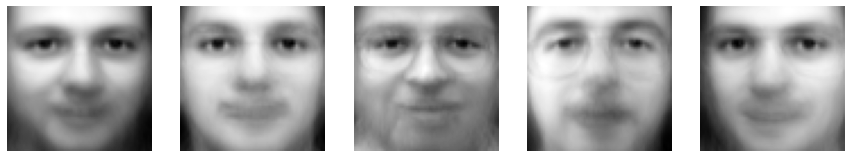

In [65]:
fig = plt.figure(figsize=(15, 5))
for i in range(0, r):
    ax = plt.subplot2grid((1, r), (int(i/r), i-int(i/r)*r))
    ax.imshow(pics[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

In [67]:
# # reconstruction of pictures with centroids
# Y = getY(kmeans.labels_)
# X = pics.T
# print(X.shape)
# print(Y.shape)
# # print((Y@X.T).shape)
# # i = 2
# # recon = Y@X.T
# # fig = plt.figure(figsize=(10, 3))
# # for i in range(30):
# #     ax = plt.subplot2grid((3, 10), (int(i/10), i-int(i/10)*10))
# #     ax.imshow(recon[i,:].reshape(64, 64), cmap=plt.cm.gray)
# #     ax.axis('off')
# pic2 = -1.2 * X[:, 4] + 2.4 * X[:, 3] + 0.3 * X[:, 0] + 0.1 * X[:, 1] + 0.2 * X[:, 2]
# print(pic2.shape)
# fig = plt.figure(figsize=(9, 3))
# ax = plt.subplot2grid((1, 1), (0, 0))
# ax.imshow(pic2.reshape(64, 64), cmap=plt.cm.gray)
# ax.set_axis_off()


In [68]:
r = 3
kmeans = KMeans(n_clusters=r).fit(D)
centroids_3 = kmeans.cluster_centers_

print(centroids.shape)
print(centroids_3.shape)

isIn = False
for i in range(0, centroids_3.shape[0]):
    isIn = False
    for j in range(0, centroids.shape[0]):
        if (centroids_3[i, :] == centroids[j, :]).all():
            isIn = True
    if isIn == False:
        break
if isIn == False:
    print("The centroids of a k-means clustering with r = 3 clusters are not a subset of the centroids of a k-means clustering with r = 5 clusters.")
else:
    print("The centroids of a k-means clustering with r = 3 clusters are a subset of the centroids of a k-means clustering with r = 5 clusters.")


(5, 4096)
(3, 4096)
The centroids of a k-means clustering with r = 3 clusters are not a subset of the centroids of a k-means clustering with r = 5 clusters.


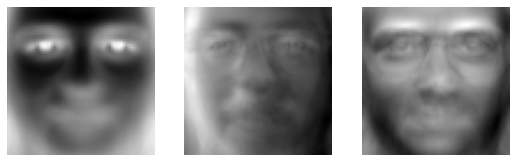

In [69]:
# feature spaces by truncated SVD: The right singular vectors of C.
r = 3
V = Vᵀ.T[:, 0:r]
fig = plt.figure(figsize=(9, 3))
for i in range(0, r):
    ax = plt.subplot2grid((1, r), (int(i/r), i-int(i/r)*r))
    ax.imshow(V.T[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

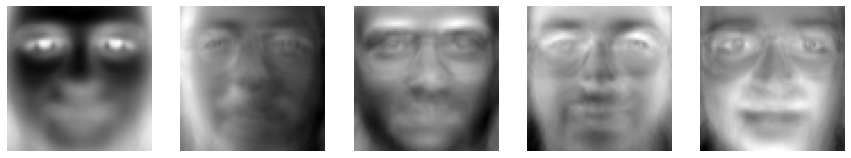

In [70]:
# feature spaces by truncated SVD: The right singular vectors of C.
r = 5
V = Vᵀ.T[:, 0:r]
fig = plt.figure(figsize=(15, 5))
for i in range(0, r):
    ax = plt.subplot2grid((1, r), (int(i/r), i-int(i/r)*r))
    ax.imshow(V.T[i,:].reshape(64, 64), cmap=plt.cm.gray)
    ax.axis('off')

# Exercise: k-means Initialization

The functions generating the datasets are given here. Every function gets as input the noise parameter ``epsilon`` and the number of points ``n`` to be sampled. It returns a tupel of the shape of clusters being generated, the dataset and the true cluster labels. 

In [71]:
def generateMoons(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    moons, labels = datasets.make_moons(n_samples=n, noise=epsilon, random_state=7)
    scaler.fit(moons)
    return "moons", scaler.transform(moons), labels, 2
def generateBlobs(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    blobs, labels = datasets.make_blobs(n_samples=n,centers=3, cluster_std=[epsilon + 1, epsilon + 2.5, epsilon + 0.5], random_state=17)
    scaler.fit(blobs)
    return "blobs", scaler.transform(blobs), labels, 3
def generateCircles(epsilon, n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    circles, labels = datasets.make_circles(n_samples=n, factor=.5, noise=epsilon, random_state=27)
    scaler.fit(circles)
    return "circ", scaler.transform(circles), labels, 2
def generateAniso(epsilon,n):
    scaler = MinMaxScaler(feature_range=(0, 3))
    A, labels = datasets.make_blobs(n_samples=n, random_state=170)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    aniso = np.dot(A, transformation)
    scaler.fit(aniso)
    return "ani", scaler.transform(aniso), labels, 3

Implement the centroid initialization here. Right now, it returns a random initialization. 

In [72]:
def init_centroids(D, r):
    n = D.shape[0]
    i = np.random.randint(0, n - 1)
    # X: each column is a centroid, D: each row is a datapoint
    X = D[i, :].T
    s = 1
    while s < r:
        # maxIndex = -1
        distSum = 0.0
        dist = np.zeros(n)
        for i in range(0, n):
            # minDist: distance to the nearest centroid(distance to the centroid which is the center of the cluster the datapoint belongs to)
            minDist = sys.maxsize
            for j in range(0, s):
                if s == 1:
                    d = np.sum(np.power(X[:].T - D[i, :], 2))
                else:
                    d = np.sum(np.power(X[:, j].T - D[i, :], 2))
                if d < minDist:
                    minDist = d
            dist[i] = minDist
            distSum += minDist

        # select next centroid, the larger the dist, the higher the possibility to be the centroid
        # weighted random sampling
        distSum *= np.random.random()
        i = -1
        for j in range(n):
            distSum -= dist[j]
            if distSum <= 0:
                i = j
                break
        # i: index of the next centroid
        X = np.column_stack((X, D[i, :].T))
        s += 1

    return X


In [73]:
def init_centroids_plus(D, r):
    n = D.shape[0]
    i = np.random.randint(0, n - 1)
    # X: each column is a centroid, D: each row is a datapoint
    X = D[i, :].T
    s = 1
    while s < r:
        # minDist: distance to the nearest centroid(distance to the centroid which is the center of the cluster the datapoint belongs to)
        minDist = sys.maxsize
        # maxDist: largest distance of the datapoint to its centroid -> higest possibility to be next centroid
        maxDist = -1
        maxIndex = -1
        distSum = 0.0
        dist = np.zeros(n)
        for i in range(0, n):
            minDist = sys.maxsize
            for j in range(0, s):
                if s == 1:
                    d = np.sum(np.power(X[:].T - D[i, :], 2))
                else:
                    d = np.sum(np.power(X[:, j].T - D[i, :], 2))
                if d < minDist:
                    minDist = d
            if minDist > maxDist:
                maxDist = minDist
                maxIndex = i

        # maxIndex: index of the next centroid
        X = np.column_stack((X, D[maxIndex, :].T))
        s += 1

    return X

In [74]:
def init_centroids_pp(D,r):
    '''
        :param r: (int) number of centroids (clusters)
        :param D: (np-array) the data matrix
        :return: (np-array) 'X' the selected centroids from the dataset
    '''   
    d = D.shape[1]
    X = np.random.rand(d,r)*3
    # X = np.random.rand(2,r)*3
    return X

This is the $k$-means implementation from the lecture accompanying notebook.

In [75]:
def RSS(D,X,Y):
    return np.sum((D- Y@X.T)**2)

In [76]:
def getY(labels):
    Y = np.zeros((len(labels), max(labels)+1))
    for i in range(0, len(labels)):
        Y[i, labels[i]] = 1
    return Y
def update_centroid(D,Y):
    cluster_sizes = np.diag(Y.T@Y).copy()
    cluster_sizes[cluster_sizes==0]=1
    return D.T@Y/cluster_sizes
def update_assignment(D,X):
    dist = np.sum(D**2,1).reshape(-1,1)  - 2* D@X + np.sum(X**2,0)
    labels = np.argmin(dist,1)
    return getY(labels)
def kmeans(D,r, X_init, epsilon=0.00001, t_max=10000):
    X = X_init.copy()
    Y = update_assignment(D,X)
    rss_old = RSS(D,X,Y) +2*epsilon
    t=0
    #Looping as long as difference of objective function values is larger than epsilon
    while rss_old - RSS(D,X,Y) > epsilon and t < t_max-1:
        rss_old = RSS(D,X,Y)
        X = update_centroid(D,Y)
        Y = update_assignment(D,X)
        t+=1
    print(t,"iterations")
    return X,Y

Test the initialization function Kmeans++:

5 iterations


NameError: name 'colors' is not defined

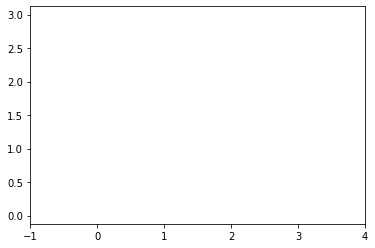

In [77]:
# test initialization function
n=500
dataID, D, labels, r = generateBlobs(0.05,n)
X_init = init_centroids(D,r)
# X_init = init_centroids_plus(D,r)
# X_init = init_centroids_pp(D,r)

X,Y = kmeans(D,r, X_init)

fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
plt.xlim(-1, 4)
plt.ylim(-1, 4)
ax.scatter(D[:, 0], D[:, 1], c=colors[np.argmax(Y,axis=1)], s=10)
# X_init: coordinates of the initial centroid; X: coordinates of the final centroid
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D')
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D')

We generate a dataset.

In [ ]:
n=500
dataID, D, labels, r = generateBlobs(0.05,n)
#dataID, D, labels, r = generateAniso(0.05,n)
#dataID, D, labels, r = generateCircles(0.05,n)
#dataID, D, labels, r = generateMoons(0.05,n)

Run kmeans and spectral clustering based on the initialization technique.

In [ ]:
X_init = init_centroids(D,r)
X,Y = kmeans(D,r, X_init)

5 iterations


Plot the clustering. The initial centroids are marked in red, and the final centroids are marked in blue. Note, that this kind of centroid visualization will however not work for spectral clustering.

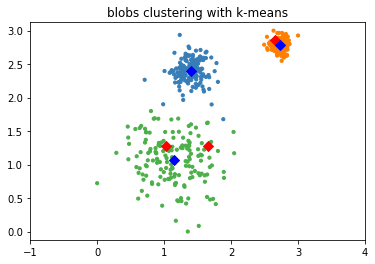

In [ ]:
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.title('blobs clustering with k-means')
ax.scatter(D[:, 0], D[:, 1], c=colors[np.argmax(Y,axis=1)], s=10)
ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=50, marker = 'D')
ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=50, marker = 'D')

In [ ]:
dataID2, D2, labels2, r2 = generateAniso(0.05,n)

18 iterations


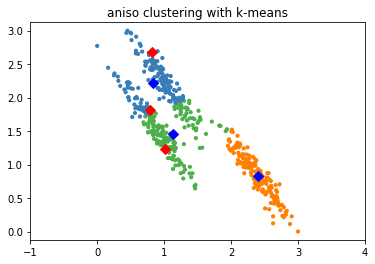

In [ ]:
X_init2 = init_centroids(D2,r2)
X2,Y2 = kmeans(D2,r2, X_init2)
fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.title('aniso clustering with k-means')
ax.scatter(D2[:, 0], D2[:, 1], c=colors[np.argmax(Y2,axis=1)], s=10)
ax.scatter(X_init2.T[:, 0], X_init2.T[:, 1], c='red', s=50, marker = 'D')
ax.scatter(X2.T[:, 0], X2.T[:, 1], c='blue', s=50, marker = 'D')

In [ ]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix, find, triu
import scipy
import pandas
from itertools import cycle, islice

In [ ]:
def spectral_clustering(W,r):
    L = np.diag(np.array(W.sum(0))[0]) - W
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM")

    kmeans = KMeans(n_clusters=r, init='k-means++')
    A = V[:,1:]
    kmeans.fit(A)
    y_pred = kmeans.labels_
    return y_pred, A

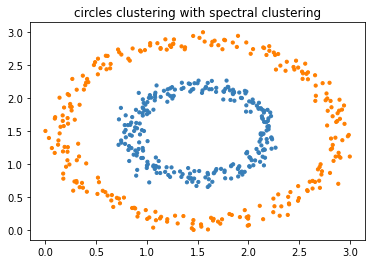

In [ ]:
dataID3, D3, labels3, r3 = generateCircles(0.05, n)
dataset_pd = pandas.DataFrame(D3)

N = kneighbors_graph(dataset_pd, n_neighbors=20, include_self=False, n_jobs=-1)
W = 0.5 * (N + N.T)

y_sc_knn, A_sc_knn = spectral_clustering(W, r3)
fig = plt.figure()
plt.scatter(D3[:, 0], D3[:, 1], s=10, c=colors[y_sc_knn])
plt.title("circles clustering with spectral clustering")
plt.show()

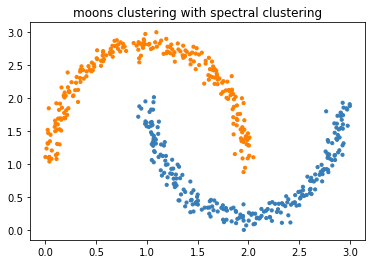

In [ ]:
dataID3, D3, labels3, r3 = generateMoons(0.05, n)
dataset_pd = pandas.DataFrame(D3)

N = kneighbors_graph(dataset_pd, n_neighbors=20, include_self=False, n_jobs=-1)
W = 0.5 * (N + N.T)

y_sc_knn, A_sc_knn = spectral_clustering(W, r3)
fig = plt.figure()
plt.scatter(D3[:, 0], D3[:, 1], s=10, c=colors[y_sc_knn])
plt.title("moons clustering with spectral clustering")
plt.show()

In [ ]:
def spectral_clustering2(W,r):
    L = np.diag(np.array(W.sum(0))[0]) - W
    Lambda, V = scipy.sparse.linalg.eigsh(L, k=r+1, which="SM")

    A = V[:,1:]
    X_init = init_centroids(A,r)
    X, Y = kmeans(A, r, X_init)
    return X, Y, X_init

2 iterations


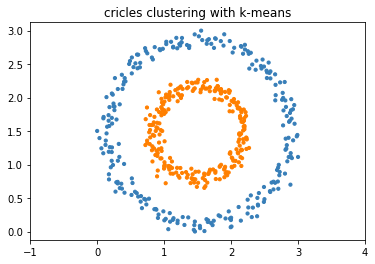

In [ ]:
dataID3, D3, labels3, r3 = generateCircles(0.05, n)
dataset_pd = pandas.DataFrame(D3)

N = kneighbors_graph(dataset_pd, n_neighbors=20, include_self=False, n_jobs=-1)
W = 0.5 * (N + N.T)

X, Y, X_init = spectral_clustering2(W, r3)

fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.title('cricles clustering with k-means')
ax.scatter(D3[:, 0], D3[:, 1], c=colors[np.argmax(Y, axis=1)], s=10)
# ax.scatter(X_init.T[:, 0], X_init5.T[:, 1], c='red', s=10, marker='D')
# ax.scatter(X.T[:, 0], X5.T[:, 1], c='blue', s=10, marker='D')

13 iterations


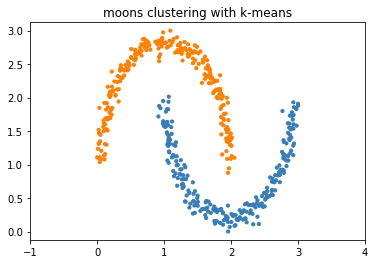

In [ ]:
dataID3, D3, labels3, r3 = generateMoons(0.05, n)
dataset_pd = pandas.DataFrame(D3)

N = kneighbors_graph(dataset_pd, n_neighbors=20, include_self=False, n_jobs=-1)
W = 0.5 * (N + N.T)

X, Y, X_init = spectral_clustering2(W, r3)

fig = plt.figure()
ax = plt.axes()
ax.axis('equal')
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.title('moons clustering with k-means')
ax.scatter(D3[:, 0], D3[:, 1], c=colors[np.argmax(Y, axis=1)], s=10)
# ax.scatter(X_init.T[:, 0], X_init.T[:, 1], c='red', s=10, marker='D')
# ax.scatter(X.T[:, 0], X.T[:, 1], c='blue', s=10, marker='D')

# Exercise : Movielens
To read the dataset you might need to alter the path to look for it:

In [78]:
# lets explore movies.csv
movies= pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [79]:
# lets explore ratings.CSV
ratings=pd.read_csv('ml-latest-small/ratings.csv',sep=',')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The original ratings are in the range of 0.5 and 5:

In [80]:
min(ratings["rating"]), max(ratings["rating"])

(0.5, 5.0)

We convert the sparse representation of movie ratings into a data matrix. The missing values are filled with zeros.

In [81]:
df_movie_ratings = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)  #fill unobserved entries with μ
df_movie_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We consider here only the movies which have been rated by more than 200 users. That are 18 movies. We will not be able to infer a pattern for movies with very few observations anyways, but for this exercise we are mostly interested in the prnciple and do not need a big dataset.

In [82]:
np.sum(np.sum(df_movie_ratings!=0,0)>200)

18

In [83]:
keep_movie = np.sum(df_movie_ratings!=0,0)>200
df_D = df_movie_ratings.loc[:,keep_movie]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


Furthermore, we will throw out all the users which have not rated more than five movies.

In [84]:
np.sum(np.sum(df_D!=0,1)>5)

344

The resulting dataset has the userID as rows and movieIDs as columns. Hence, userID 1 and 4 addresses the first two rows of this dataset.

In [85]:
keep_user = np.sum(df_D!=0,1)>5
df_D = df_D.loc[keep_user,:]
df_D.head()

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,4.0,1.0,5.0,4.0,0.0,2.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,0.0,0.0,0.0,0.0
7,4.5,0.0,4.5,0.0,4.5,5.0,0.0,0.0,5.0,5.0,0.0,2.5,5.0,4.5,4.0,0.0,4.0,0.0


The movie number- title assignments are given as follows:

In [86]:
movies.loc[movies['movieId'].isin(df_D.columns)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


The resulting data matrix is given as follows:

In [87]:
D = df_D.to_numpy()
D.shape

(344, 18)

In [88]:
t_max = 100
λ = 0.00001
r = 5

In [89]:
def matrix_completion(D, r, λ):
    n = D.shape[0]
    d = D.shape[1]
    X = np.random.rand(d * r).reshape(d, r)
    Y = np.random.rand(n * r).reshape(n, r)
    O = indicator_nonzero(D)
    t = 1
    MESO = np.zeros(t_max)
    while t <= t_max:
        for k in range(0, d):
            O_X = np.zeros(n)
            for j in range(0, n):
                O_X[j] = O[j, k]
            O_X = np.diag(O_X)
            X[k, :] = D[:, k].T@Y@np.linalg.inv(Y.T@O_X@Y + λ)

        for i in range(0, n):
            O_Y = np.zeros(d)
            for j in range(0, d):
                O_Y[j] = O[i, j]
            O_Y = np.diag(O_Y)
            Y[i, :] = D[i, :]@X@np.linalg.inv(X.T@O_Y@X + λ)

        MESO[t - 1] = np.sum(np.power(D - O * (Y@X.T), 2)) / np.sum(O)
        t += 1
    return X, Y, MESO

def indicator_nonzero(D):
    n = D.shape[0]
    d = D.shape[1]
    O = np.zeros(n * d).reshape(n, d)
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            if D[i][j] != 0:
                O[i][j] = 1
    return O

In [90]:
X, Y, MESO = matrix_completion(D, r, λ)

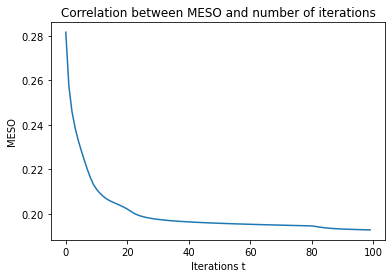

In [91]:
# plot: iterations aganst MSEO
t = np.array([i for i in range(MESO.shape[0])])

plt.figure()
plt.title("Correlation between MESO and number of iterations")
ax = plt.gca()
ax.set_xlabel('Iterations t')
ax.set_ylabel('MESO')
ax.plot(t, MESO)
plt.show()


In [92]:
import math

In [93]:
def matrix_completion_modified(D, r, λ):
    n = D.shape[0]
    d = D.shape[1]
    X = np.random.rand(d * r).reshape(d, r)
    Y = np.random.rand(n * r).reshape(n, r)
    O = indicator_nonzero(D)
    t = 1
    MESO = np.zeros(t_max)
    threshold = 1e-3
    while t <= t_max:
        if t >= 3 and math.isclose(MESO[t - 2], MESO[t - 3], rel_tol=threshold):
            break
        for k in range(0, d):
            O_X = np.zeros(n)
            for j in range(0, n):
                O_X[j] = O[j, k]
            O_X = np.diag(O_X)
            X[k, :] = D[:, k].T@Y@np.linalg.inv(Y.T@O_X@Y + λ)

        for i in range(0, n):
            O_Y = np.zeros(d)
            for j in range(0, d):
                O_Y[j] = O[i, j]
            O_Y = np.diag(O_Y)
            Y[i, :] = D[i, :]@X@np.linalg.inv(X.T@O_Y@X + λ)

        MESO[t - 1] = np.sum(np.power(D - O * (Y@X.T), 2)) / np.sum(O)
        t += 1
    return X, Y, MESO, t - 1

In [94]:
X2, Y2, MESO2, t2 = matrix_completion_modified(D, r, λ)
print(t2, "iterations")

30 iterations


In [95]:
print("MSEO obtained for 100 iterations: ", MESO[MESO.shape[0] - 1])
print("MSEO derived by stopping criterion: ", MESO2[t2 - 1])

MSEO obtained for 100 iterations:  0.1927202093012956
MSEO derived by stopping criterion:  0.1960413992138375


In [96]:
df_D.head(3)

movieId,1,47,50,110,150,260,296,318,356,480,527,589,593,780,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,,,,
1,4.0,5.0,5.0,4.0,0.0,5.0,3.0,0.0,4.0,4.0,5.0,0.0,4.0,3.0,5.0,5.0,5.0,5.0
4,0.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,5.0,2.0
5,4.0,0.0,4.0,4.0,3.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
λ = 0.0001
X22, Y22, MESO22, t22= matrix_completion_modified(D, r, λ)
recon22 = Y22@X22.T
df = pd.DataFrame(np.around(recon22[0:3, :], 2))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4.06,4.35,4.57,4.30,3.72,5.02,4.41,4.68,3.79,4.03,4.22,4.46,4.44,3.42,5.02,4.61,4.90,4.94
1,73.99,2.16,-6.67,-0.98,79.39,5.37,1.48,0.23,-11.88,-5.20,-12.53,-5.44,4.15,-48.55,4.55,1.29,5.52,1.48
2,3.63,3.04,3.96,3.27,3.34,3.41,4.62,4.03,4.97,2.96,5.03,3.05,3.91,1.89,3.35,3.60,2.32,2.73


In [98]:
λ = 0.1
X3, Y3, MESO3, t3= matrix_completion_modified(D, r, λ)
recon3 = Y3@X3.T
df = pd.DataFrame(np.around(recon3[0:3, :], 2))
df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3.99,4.27,4.57,4.17,3.63,5.12,4.66,4.69,4.29,3.80,4.45,4.00,4.48,2.74,5.09,4.56,4.69,4.81
1,-7.06,2.24,-0.99,10.10,9.79,4.91,1.15,7.19,6.98,7.61,9.42,4.61,4.18,-3.22,5.12,1.36,5.28,1.59
2,3.75,4.13,4.31,3.32,3.21,3.22,4.50,4.28,3.65,3.06,4.27,3.19,4.07,1.08,3.22,3.57,5.15,4.72


In [99]:
λ = 0.5
X4, Y4, MESO4, t4= matrix_completion_modified(D, r, λ)
recon4 = Y4@X4.T
df = pd.DataFrame(np.around(recon4[0:3, :], 2))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3.83,4.21,4.63,3.98,3.69,5.30,4.53,4.55,4.20,3.71,4.60,3.66,4.40,3.18,5.28,4.71,4.71,4.63
1,3.35,3.03,3.82,-11.68,-10.34,5.16,1.19,-3.92,-4.46,-6.05,-2.23,-14.54,4.01,-8.49,4.99,0.57,4.97,2.11
2,4.02,4.60,4.49,3.46,3.38,5.85,4.36,3.93,3.88,3.96,4.29,3.09,4.60,3.59,5.81,5.25,4.15,4.40


In [100]:
λ = 1
X5, Y5, MESO5, t5= matrix_completion_modified(D, r, λ)
recon5 = Y5@X5.T
df = pd.DataFrame(np.around(recon5[0:3, :], 2))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,3.83,4.39,4.71,4.47,3.89,4.62,4.78,4.76,4.34,3.83,4.59,4.54,4.52,2.94,4.62,4.70,4.79,4.78
1,2.66,2.80,2.75,12.52,15.10,5.34,1.45,2.47,1.31,9.95,2.19,23.41,4.01,-2.84,5.04,0.73,4.95,1.70
2,3.76,3.89,4.24,3.55,3.34,4.77,4.63,4.29,4.05,3.41,4.17,2.99,4.27,3.72,4.77,4.96,3.31,4.02


In [101]:
print("λ = 1, MSEO = ", MESO5[t5 - 1])
print("λ = 0.5, MSEO = ", MESO4[t4 - 1])
print("λ = 0.1, MSEO = ", MESO3[t3 - 1])
print("λ = 0.0001, MSEO = ", MESO22[t22 - 1])

λ = 1, MSEO =  0.213641227313919
λ = 0.5, MSEO =  0.20201241887248955
λ = 0.1, MSEO =  0.19511805080093025
λ = 0.0001, MSEO =  0.19367667616943007


(b) (???) No. The objective is convex as it is the sum of convex functions. However, X and Y in objective function may not in feasible set.

(c) When the iterate is convergent, the difference between of MSEO between the two iterations is sufficient small. Here, we set the thereshold 1e-3, that means, if the difference of MSEO between two consecutive iterations is smaller than 1e-3, then the program stops.

Using this strategy, the final MESO is 0.20388659041539023, which is close to the MESO derived after 100 iterations, 0.19464753157757878.

(d) Based on above predicted matrices for λ ∈ { 1, 0.5, 0.1, 0.0001 }, we choose λ = 0.5. The iterations in the four cases are all stopped by the selected stopping criterion. As there the MSEOs derived with four different λ values are close, we mainly consider the interpretability.
- λ = 0.0001: some prediction values of the second user are much larger than 5, which cannot be interpretated. Besides, there is a negative predicted value for the third user. It is unrealistic.
- λ = 0.01: More than half of the prediction values of the second user are larger than 5, some even reach 32.
- λ = 0.5: Almost all values are in the range [0, 5]. The most values that are used to be the observation valus in the original matrix D are also close the the original ture values.
- λ = 1: Some predictions for the second user are negative.

(However, the above shown matrices may vary in different runs. Large outliers may also appear in the prediction matrix of λ = 0.5 sometimes. Therefore, we run the program multiple times, and choose λ = 0.5 because it performs better generally.)


